In [1]:
import numpy as np
np.seterr(all='raise')
import sys
sys.path.append('../')

from meshmaker.base import Base, Laziness
from meshmaker.model import Model
from meshmaker.mesh import Mesh
from meshmaker.tform import TForm
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.geometry import batch, slide, loop_offset, loop_normal, isnear, near, loopO
from meshmaker.mgl import Window as GLWindow
from meshmaker.plt import *
from collections import defaultdict
import json

def show(class_with_scene_method, texture_directory='../resources/textures', **kws):
    GLWindow(class_with_scene_method, texture_directory, **kws)

GLWindow.test('../resources/textures')

Loaded texture: generic_0 (../resources/textures/generics/generic_0.png)


In [90]:
from meshmaker.planargraph import planargraph

def loop_difference(l1, l2):
    l1 = [p.quant() for p in l1]
    l2 = [p.quant() for p in l2]
    segs = list(slide(l1, 2)) + list(slide(l2, 2))
    pg = planargraph(segs=segs)
    _, iloops = pg.polygon()
    parts = []
    for loop in iloops:
        for p in loop:
            if not p.inbxy(l2, True):
                parts.append(loop)
                break
    return parts

def loop_union(l1, l2):
    l1 = [p.quant() for p in l1]
    l2 = [p.quant() for p in l2]
    segs = list(slide(list(l1), 2)) + list(slide(list(l2), 2))
    pg = planargraph(segs=segs)
    union, _ = pg.polygon()
    return union

def loop_intersection(l1, l2):
    l1 = [p.quant() for p in l1]
    l2 = [p.quant() for p in l2]
    segs = list(slide(l1, 2)) + list(slide(l2, 2))
    pg = planargraph(segs=segs)
    _, iloops = pg.polygon()
    parts = []
    print(len(iloops))
    for loop in iloops:
        print(loop)
        for p in loop:
            #if p.inbxy(l1, True) and p.onbxy(l2, True):
            #    continue
            #elif p.onbxy(l1, True) and p.inbxy(l2, True):
            #    continue
            if (p.inbxy(l1, True) and p.inbxy(l2, True)):
                continue
            else:
                f, ax = plot()
                plot_pg(ax, pg)
                for u, v in segs:
                    plot_edge(ax, u, v, col='r', lw=1)
                #plot_loop(ax, l1, col='g')
                #plot_loop(ax, l2, col='b')
                plot_point(ax, p, mk='*')
                break
        else:
            parts.append(loop)
    return parts

1
[vec3(0.8090, -0.5878, 0.0000), vec3(0.8090, 0.5878, 0.0000), vec3(0.1420, 0.8045, 1.0000), vec3(0.6910, 0.0489, 1.0000), vec3(0.1420, 0.8045, 1.0000), vec3(-0.3090, 0.9511, 0.0000), vec3(-1.0000, 0.0000, 0.0000), vec3(-0.3090, -0.9511, 0.0000)]


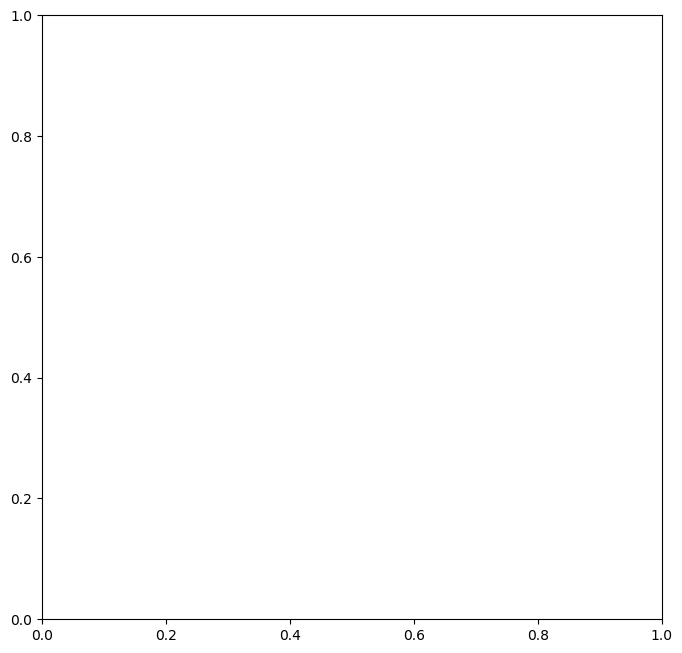

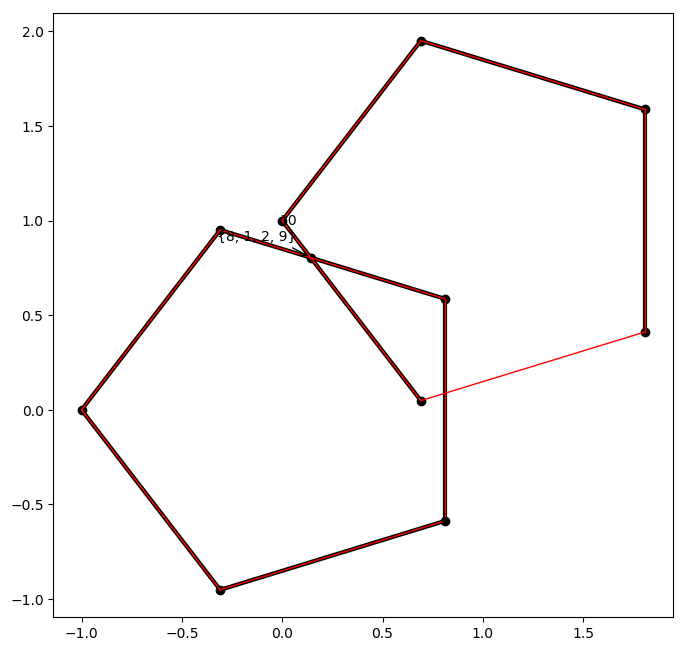

In [91]:
a = vec3.O().ring(1, 5)
b = vec3.U().ring(1, 5)

f, ax = plot()
for part in loop_intersection(a, b):
    plot_loop(ax, part)


In [3]:
def factoryfeature(f):
    """Decorator to cache function results based on kws"""
    lookup = {}
    def wrap(*ags, **kws):
        key = json.dumps(kws, sort_keys=True)
        feature = lookup.get(key)
        if feature is None:
            feature = f(*ags, **kws)
            lookup[key] = feature
        if callable(feature):
            feature.__name__ += f'_{key}'
        return feature
    return wrap

In [4]:
class ParamMesh(Base):
    """Proxy class for representing hierarchical
    mesh parameterizations via control meshes"""
    
    def __init__(self, control, **kws):
        super().__init__(features=[], **kws)
        self.control = control
        self.showcontrol = False
        self.selected = [f for f, face in control]
        
        from pyglet.window import key
        self.parameters = {
            key.C: self.on_toggle, key.SPACE: self.on_cycle,
            key.UP: self.on_up, key.DOWN: self.on_down,
            key.LEFT: self.on_left, key.RIGHT: self.on_right,
            key.J: self.on_j, key.K: self.on_k,
        }

    def on_toggle(self, *ags):
        self.showcontrol = not self.showcontrol
    def on_cycle(self, *ags):
        self.selected.append(self.selected.pop(0))
    def on_left(self, *ags):
        vec3(0.5, 1, 1).sclps(self.control.vertices)
    def on_right(self, *ags):
        vec3(2, 1, 1).sclps(self.control.vertices)
    def on_up(self, *ags):
        vec3(1, 2, 1).sclps(self.control.vertices)
    def on_down(self, *ags):
        vec3(1, 0.5, 1).sclps(self.control.vertices)
    def on_j(self, *ags):
        vec3(1, 1, 0.5).sclps(self.control.vertices)
    def on_k(self, *ags):
        vec3(1, 1, 2).sclps(self.control.vertices)
        
    def scene(self):
        if self.showcontrol:
            s = self.selected[0]
            sface = self.control.faces[s]
            sface = [self.control.vertices[v].cp() for v in sface]
            sface = (self.control.face_normals()[s] * 0.001).trnps(sface)
            selected = Mesh()
            selected.af(sface)
            meshes = {'generic_1': [self.control],
                      'generic_8': [selected]}
            parts = [TForm(models=[Model(meshes=meshes)])]
        else:
            parts = [f(self.control, target) for f, target in self.features]
        return TForm(children=parts)

    @staticmethod
    def textured(texture):
        def facefeature(control, faces):
            mesh = Mesh()
            for f in faces:
                loop = [control.vertices[v] for v in control.faces[f]]
                mesh.af(loop)
            return TForm(models=[Model(meshes={texture: [mesh]})])
        facefeature.__name__ = texture
        return facefeature

    
class MetaMesh(ParamMesh):
    """A ParamMesh where features are inferred from meta data
    associated with the simplices of the control mesh"""

    def metafeatures(self, **kws):
        """Aggregate feature data based on control mesh meta data."""
        features = defaultdict(list)
        methods = {}
        for f, face in self.control:
            metas = self.control.meta.get(f)
            if not isinstance(metas, tuple):
                metas = (metas, )
            for meta in metas:
                if callable(meta):
                    methods[meta.__name__] = meta
                    features[meta.__name__].append(f)
                elif meta is not None:
                    raise ValueError(f'whats goin on here: {meta}')
        return [(methods[m], faces) for m, faces in features.items()]
        
    def parameterize(self, **kws):
        """Trivial parameterization covers all faces with generic_0.
        Baseclasses should add complexity."""
        generic = self.textured('generic_0')
        for f, face in self.control:
            self.control.meta[f] = generic
    
    def __init__(self, control, **kws):
        super().__init__(control, **kws)
        self.parameterize(**kws)
        self.features = self.metafeatures(**kws)

In [5]:
def autotile(w, h, fill_texture, max_nx=None, max_ny=None):
    
    chunk = [vec3(0, 0, 0), vec3(w, 0, 0), vec3(w, 0, h), vec3(0, 0, h)]
    chunkN = loop_normal(chunk)

    def tiles(loop, chunk_w=1.01, chunk_h=1.01):
        """Chunk a rectangular space into a grid"""
        lw = loop[0].d(loop[ 1])
        lh = loop[0].d(loop[-1])
        nx = int(lw / chunk_w)
        ny = int(lh / chunk_h)
        nx = nx if max_nx is None else min(max_nx, nx)
        ny = ny if max_ny is None else min(max_ny, ny)
        X = (loop[ 1] - loop[0]).nrm()
        Y = (loop[-1] - loop[0]).nrm()
        dx = near((lw - nx * chunk_w) / 2, 0)
        dy = near((lh - ny * chunk_h) / 2, 0)
        
        positions = []
        if nx > 0 and ny > 0:
            for x in range(0, nx):
                x = x * chunk_w + dx
                for y in range(0, ny):
                    y = y * chunk_h + dy
                    positions.append(loop[0] + X * x + Y * y)
        
        if positions:
            assert (nx > 0 and ny > 0)
            return positions, borders(loop, dx, dy, X, Y)
        else:
            return positions, [(loop, ())]

    def borders(loop, dx, dy, X, Y):
        if dx > 0 and dy > 0:
            hole = [loop[0] + X * dx + Y * dy,
                    loop[1] - X * dx + Y * dy,
                    loop[2] - X * dx - Y * dy,
                    loop[3] + X * dx - Y * dy]
            borders = [(loop, (hole, ))]
        elif dx > 0 and dy == 0:
            left = [loop[0].cp(), loop[0] + X * dx,
                    loop[3] + X * dx, loop[3].cp()]
            right = [loop[1] - X * dx, loop[1].cp(),
                     loop[2].cp(), loop[2] - X * dx]
            borders = [(left, ()), (right, ())]            
        elif dx == 0 and dy > 0:
            top = [loop[3] - Y * dy, loop[2] - Y * dy,
                   loop[2].cp(), loop[3].cp()]
            bottom = [loop[0].cp(), loop[1].cp(),
                      loop[1] + Y * dy, loop[0] + Y * dy]
            borders = [(top, ()), (bottom, ())]
        elif dx == 0 and dy == 0:
            borders = []
        else:
            print(dx, dy)
            raise
        return borders

    def g(f):
        """f would normally generate meshes for a rectangular loop ->
        instead presplit its domain into regular chunks and reuse its
        result to cover the original domain, filling in the fat with
        boring meshes"""
        
        cached = f(chunk)
        
        def tiled(rect):
            
            #o = loopO(rect)
            #print()
            #print(rect)
            #print()
            #rect = rect[o:] + rect[:o]

            rectN = loop_normal(rect)
            if chunkN.isnear(rectN):
                q = None
            elif chunkN.isnear(rectN.fp()):            
                q = quat.av(-np.pi, vec3.Z())
            else:
                q = quat.uu(chunkN, rectN)
            
            positions, borders = tiles(rect, w, h)
            
            chunks = [TForm(t=t, q=q) for t in positions]
            for tf in chunks:
                if isinstance(cached, list):
                    cp = cached[0].cp()
                    cached.append(cached.pop(0))
                else:
                    cp = cached.cp()
                tf.add(cp)

            fill = Mesh()
            #fill.af([p.cp().ytrn(0.01) for p in rect])
            for border in borders:
                fill.apy(border)
            fill = Model(meshes={fill_texture: [fill]})
            
            #marker = TForm(t=rect[0].lerp(rect[1], 0.25), models=[Model.cube_model('generic_11', r=0.1)])
            #return TForm(children=(chunks + [marker]), models=[fill])
            
            return TForm(children=chunks, models=[fill])

        return tiled

    return g


@autotile(2, 0.1, 'generic_8', max_ny=1)
def testtile(rect):
    #rect = loop_offset(rect, 0.01)
    texture = 'generic_7'
    mesh = Mesh()
    mesh.af(rect)
    return TForm(models=[Model(meshes={texture: [mesh]})])



loop = [vec3(0, 0, 0), vec3(5, 2, 0), vec3(5, 2, 1), vec3(0, 0, 1)]
show(Base(scene=lambda : testtile(loop)))

Loaded texture: generic_7 (../resources/textures/generics/generic_7.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)


In [6]:
class Seam(Base):
    
    """need a parameterization of a loop for windows"""
    
    @classmethod
    def l2s(cls, loop):
        s = [cls(u, v) for u, v in slide(loop, 2)]
        for i in range(1, len(s)):
            s[i - 1].next = s[i]
        return s[0]
    
    def __init__(self, u, v, n=0, du=None, dv=None, **kws):
        du = (v - u).nrm() if du is None else du
        dv = (u - v).nrm() if dv is None else dv
        super().__init__(u=u, v=v, n=n, du=du, dv=dv, **kws)

    def __iter__(self):
        yield from self._iter()
        
    def _iter(self, n=None):
        m = self.n if n is None else n
        if m == 0:
            yield self.u
            #yield self.v
        else:
            yield self.u
            yield from self.u.spline(self.v, self.du, self.dv, m, alpha=1)
        if not (hasattr(self, 'next') and self.next.u.isnear(self.v)):
            yield self.v
        if hasattr(self, 'next'):
            yield from self.next._iter(n=n)

    def _control(self):
        unique = []
        for p in self._iter(n=0):
            if not p in unique:
                unique.append(p)
        return unique

    def trn(self, t):
        t.trnps(self._control())
        return self

    def scl(self, s):
        s.sclps(self._control())
        return self
            
    def rot(self, q):
        q.rot(self._control())
        return self

    def cp(self, root=True):
        cp = Seam(self.u.cp(), self.v.cp(), self.n,
                  self.du.cp(), self.dv.cp())
        if hasattr(self, 'next'):
            cp.next = self.next.cp(False)
            cp.next.u = cp.v
        if root and self._closed():
            cp._last().v = cp.u
        return cp
            
    def _last(self):
        return self.next._last() if hasattr(self, 'next') else self
        
    def _closed(self):
        return self._last().v.isnear(self.u)
        
    def loop(self, n=None):
        points = list(self._iter(n=n))
        if self._closed():
            points.pop(-1)
        return points
            

def test():
    a, b, c = vec3(0, 0, 0), vec3(1, 3, 0), vec3(0, 3, 0)
    
    du, dv = vec3(.1, 0, 0), vec3(0, -.1, 0)
    
    s2 = Seam(b, c, du=dv.fp(), dv=du, n=4)
    s1 = Seam(a, b, du=du, dv=dv, n=5, next=s2)
    
    s3 = s1.cp()
    vec3.X().trnps(s3.loop(n=0))
    
    f, ax = plot()
    plot_edges(ax, list(s1), mk='s', col='g')
    plot_edges(ax, list(s3), mk='*', col='b')
    ax.set_aspect(1)

    #b.trn(vec3(-1, -1, 0))
    
    #f, ax = plot()
    #plot_edges(ax, list(s1), mk='s', col='g')
    #plot_edges(ax, list(s2), mk='*', col='b')
    #ax.set_aspect(1)

#test()

In [7]:
def box(w, h, d):
    loop = [vec3(-w / 2, -d, 0), vec3( w / 2, -d, 0),
            vec3( w / 2, -d, h), vec3(-w / 2, -d, h)]
    return loop

In [8]:
class Factory(Base):

    @classmethod
    def lineup(cls, *ags, dx=1, **kws):
        prefabs = cls.scenes(*ags, **kws)
        for i, pf in enumerate(prefabs):
            pf.translate(vec3.X(dx * i))
        return Base(scene=(lambda : TForm(children=prefabs)))
    
    #@factoryfeature
    @classmethod
    def prefabs(cls, *ags, **kws):
        return [cls(**pf) for pf in cls.blueprints(*ags, **kws)]

    @classmethod
    def scenes(cls, *ags, **kws):
        return [pf.scene(*ags, **kws) for pf in cls.prefabs(*ags, **kws)]

    def scene(self, *ags, **kws):
        return TForm(models=self.models(*ags, **kws))
    
    @classmethod
    def blueprints(cls):
        """generate list of prefab dicts"""
        raise NotImplementedError
    
    def models(self, *ags, **kws):
        """generate list of models"""
        raise NotImplementedError
        
        
class PortalFactory(Factory):

    """
    portal prefab: Seam object, sequence of methods
    """
    
    def __init__(self, seam, methods, **kws):
        self.N = loop_normal(seam)
        if self.N.isnear(vec3.Z()):
            self.T = vec3.X()
        else:
            self.T = vec3.Z().crs(self.N).nrm()
        super().__init__(seam=seam, methods=methods, **kws)

    def models(self):
        seam = [p.cp() for p in self.seam]
        models = []
        for method in self.methods:
            model, seam = method(seam)
            if isinstance(model, Model):
                models.append(model)
        return models


class WindowFactory(PortalFactory):
    
    rng = np.random.default_rng(0)
    
    def __init__(self, seam, jamb_width=0.02, jamb_depth=0.04, **kws):
        
        N = loop_normal(seam)
        X = vec3.Z().crs(N).nrm()                                                                 
        Y = N.crs(X).nrm()                                                                        
        loop = [vec3(p.dot(X), p.dot(Y), 0) for p in seam]
        self.ww = loop[0].d(loop[ 1])
        self.wh = loop[0].d(loop[-1])
        self.wz = loop[0].z
        
        methods = (self.make_sill, self.make_jamb, self.make_pane)
        super().__init__(seam, methods,
                         jamb_width=jamb_width,
                         jamb_depth=jamb_depth, **kws)

    def make_sill(self, loop, **kws):
        w, h, d = 0.01, 0.04, 0.04

        mesh = Mesh()
        mesh.uvs = {}

        u, v = loop[0], loop[1]
        lip = [u - self.T * w, u - self.T * w + self.N * d,
               v + self.T * w + self.N * d, v + self.T * w]
        rim = vec3.nZ(h).trnps([p.cp() for p in lip])
        top = mesh.af(lip)
        bot = mesh.af(rim[::-1])
        sides = mesh.bridge(rim, lip, m=1)
        uvo = vec3.com([mesh.vertices[v] for v in mesh.faces[sides[1]]])
        seams = [edge for seam in mesh.perimeter(sides) for edge in seam]
        mesh.uvs = mesh.unwrap_uvs(sides[1], O=(uvo, vec3.O()),
                                   seams=seams, uvs=mesh.uvs)
        if len(loop) == 4:
        
            '''
            rail = loop[2:]
            rail.insert(0, rail[0] + (rail[0] - rail[1]).nrm() * w)
            rail.append(rail[-1] + (rail[-1] - rail[-2]).nrm() * w)
            rail.reverse()
            rim = [(p + self.N * d) for p in rail] + rail[::-1]
            rim.insert(0, rim.pop(-1))
            print(rail)
            print(rim)
            '''

            u, v = loop[-1], loop[2]
            rim = [u - self.T * w, u - self.T * w + self.N * d,
                   v + self.T * w + self.N * d, v + self.T * w]
        
            lip = vec3.Z(h).trnps([p.cp() for p in rim])
            top = mesh.af(lip)
            bot = mesh.af(rim[::-1])
            #top = mesh.apy((lip, ()))
            #bot = mesh.apy((rim[::-1], ()))
            sides = mesh.bridge(rim, lip, m=1)
            uvo = vec3.com([mesh.vertices[v] for v in mesh.faces[sides[1]]])
            seams = [edge for seam in mesh.perimeter(sides) for edge in seam]
            mesh.uvs = mesh.unwrap_uvs(sides[1], O=(uvo, vec3.O()),
                                       seams=seams, uvs=mesh.uvs)        
        
        return Model(meshes={self.sill_texture: [mesh]}), loop

    def make_jamb(self, loop, **kws):
        """Create reusable model for the window.
        Hide the edges of loop with a mesh"""
        N = loop_normal(loop)
        innerseam = loop_offset(loop, self.jamb_width)

        loops = []
        loops.append((N * (self.jamb_depth / 2)).trnps([p.cp() for p in loop]))
        loops.append(loop_offset(loops[-1], self.jamb_width))
        loops.append((N * (-self.jamb_depth)).trnps([p.cp() for p in loops[-1]]))
        loops.append(loop_offset(loops[-1], -self.jamb_width))
        loops = [list(loop) for loop in zip(*loops)]
        loops.reverse()

        mesh = Mesh()
        patches = mesh.bridges(loops, n=1, m=0)        

        mesh.uvs = {}
        for patch in patches:
            seams = mesh.perimeter(patch)[0]
            patchloop = [mesh.vertices[v] for v in mesh.faces[patch[1]]]
            mesh.uvs = mesh.unwrap_uvs(patch[1],
                O=(vec3.com(patchloop), vec3(0.5, 0.5, 0)), X=self.N,
                seams=seams, uvs=mesh.uvs)
        
        return Model(meshes={self.jamb_texture: [mesh]}), innerseam

    def make_pane(self, loop, **kws):
        mesh = Mesh()
        mesh.fan(vec3.com(loop), loop)
        return Model(meshes={self.pane_texture: [mesh]}), loop

    #@factoryfeature
    @classmethod
    def blueprints(cls):
        bps = [
            dict(seam=vec3.Z(0.20).trnps(box(0.3, 0.6, 0.0)),
                 pane_texture='generic_10',
                 sill_texture='generic_8',
                 jamb_texture='generic_13'),
            dict(seam=vec3.Z(0.40).trnps(box(0.6, 0.4, 0.0)),
                 pane_texture='generic_10',
                 sill_texture='generic_8',
                 jamb_texture='generic_12'),
            dict(seam=vec3.Z(0.20).trnps(box(0.4, 0.6, 0.0)),
                 pane_texture='generic_10',
                 sill_texture='generic_8',
                 jamb_texture='generic_11'),
            dict(seam=vec3.Z(0.01).trnps(box(0.4, 0.8, 0.0)),
                 pane_texture='generic_10',
                 sill_texture='generic_8',
                 jamb_texture='generic_9'),
        ]
        return bps
    
    @classmethod
    def random(cls, door=False, seed=None):
        bps = cls.blueprints()
        rng = cls.rng if seed is None else np.random.default_rng(seed)
        while True:
            if door:
                bp = bps[3]
            else:
                bp = rng.choice(bps[:3])
            yield cls(**bp)

#show(WindowFactory(vec3.Z(0.2).trnps(box(0.2, 0.4, 0.1))))
show(WindowFactory.lineup())

# broken
#show(WindowFactory.random())


Loaded texture: generic_13 (../resources/textures/generics/generic_13.png)
Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_12 (../resources/textures/generics/generic_12.png)
Loaded texture: generic_10 (../resources/textures/generics/generic_10.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)
Loaded texture: generic_9 (../resources/textures/generics/generic_9.png)


In [9]:
class WallFactory(Factory):
    
    def __init__(self, windowfactory, wall_texture='generic_1', **kws):
        """ need representation of sub-factory constraints... """
        super().__init__(windowfactory=windowfactory,
                         wall_texture=wall_texture, **kws)

    def place_windows(self, wl, wh, chunk_w, chunk_h, max_nx=None, max_ny=None):
        nx = int(wl / chunk_w)
        nx = min(nx, max_nx) if max_nx is not None else nx
        ny = int(wh / chunk_h)
        ny = min(ny, max_ny) if max_ny is not None else ny
        xs = np.linspace(0, 1, nx * 2 + 1)[1::2]
        ys = np.linspace(0, 1, ny + 1)[:-1]
        placements = []
        for x in xs:
            for y in ys:
                placements.append((x, y, 0))
        return placements

    def make_windows(self, loop, windowfactory, **kws):
        wl = round(loop[0].d(loop[ 1]), 1)
        wh = round(loop[0].d(loop[-1]), 1)
        wallN = loop_normal(loop)
        wallX = vec3.Z().crs(wallN).nrm() * wl
        wallY = wallN.crs(wallX).nrm() * wh
        
        window = windowfactory.models()
        windowN = windowfactory.N
        seam = windowfactory.seam
        window_w = (windowfactory.ww)
        window_h = (windowfactory.wh + windowfactory.wz)
        dN = windowfactory.jamb_depth / 2
        
        if windowN.isnear(wallN):
            q = None
        elif windowN.isnear(wallN.fp()):            
            q = quat.av(-np.pi, vec3.Z())
        else:
            q = quat.uu(windowN, wallN)
        
        nx = getattr(self, 'nx', kws.get('nx', None))
        ny = getattr(self, 'ny', kws.get('ny', None))
                
        chunk_w = 1.2 * window_w
        chunk_h = 1.2 * window_h
        placements = self.place_windows(wl, wh, chunk_w, chunk_h,
                                        max_nx=nx, max_ny=ny)

        windows, holes = [], []
        for u, v, w in placements:
            t = loop[0] + wallX * u + wallY * v + wallN * (w - dN)
            tf = TForm(t=t, q=q, models=window)
            hole = (wallN * dN).trnps(tf.transform(seam))
            windows.append(tf)
            holes.append(hole)
        return windows, holes

    def make_wall(self, loop, holes, **kws):
        try:
            mesh = Mesh()
            mesh.apy(([p.cp() for p in loop],
                      [[p.cp() for p in hole] for hole in holes]))
            mesh.uvs = mesh.unwrap_uvs()
            return [Model(meshes={self.wall_texture: [mesh]})]
        except:
            print('failed to triangulate wall!')
            print((loop, holes))
            print()
            raise
            return []

    def scene(self, loop, **kws):
        if isinstance(self.windowfactory, WindowFactory):
            windowfactory = self.windowfactory
        else:
            windowfactory = next(self.windowfactory)
        windows, holes = self.make_windows(loop, windowfactory, **kws)
        wall = self.make_wall(loop, holes, **kws)
        return TForm(models=wall, children=windows)

#wf = WallFactory(windowfactory=WindowFactory.prefabs()[3])
wf = WallFactory(windowfactory=WindowFactory.random(seed=0))
loop = box(2, 1, -1)
show(Base(scene=lambda : wf.scene(loop, nx=3)))

Loaded texture: generic_1 (../resources/textures/generics/generic_1.png)
Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_10 (../resources/textures/generics/generic_10.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)


17
True


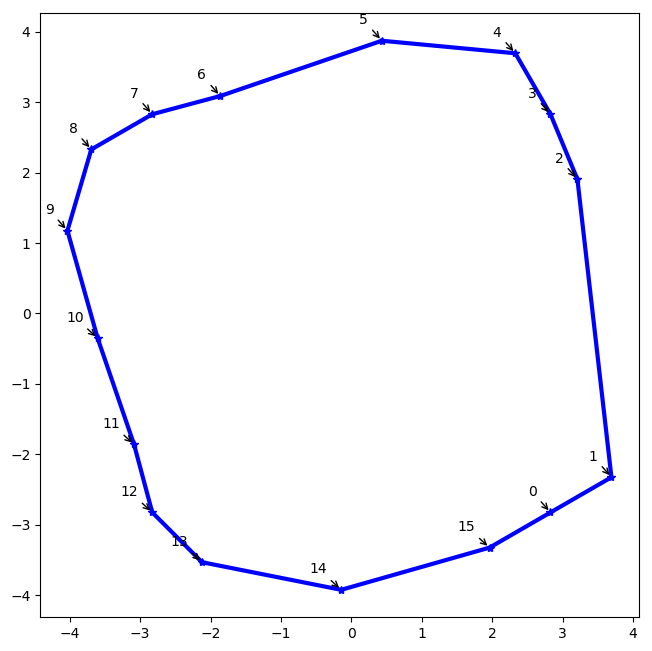

In [10]:
def fp_ex():
    loop = vec3.O().ring(4, 4)
    s = [Seam(u, v) for u, v in slide(loop, 2)]
    for i in range(1, len(s)):
        s[i - 1].next = s[i]

    s[0].n = 2
    s[0].du.rot(quat.rotz(-np.pi / 3))
    s[0].dv.rot(quat.rotz( np.pi / 8))

    s[1].n = 3
    s[1].du.rot(quat.rotz(-np.pi / 3))
    s[1].dv.rot(quat.rotz( np.pi / 12))
    
    s[2].n = 4
    s[2].du.rot(quat.rotz(-np.pi / 3))
    s[2].dv.rot(quat.rotz( np.pi / 12))
    
    s[3].n = 3
    s[3].du.rot(quat.rotz(-np.pi / 4))
    s[3].dv.rot(quat.rotz( np.pi / 6))
    
    print(len(list(s[0])))
    print(list(s[0])[0].isnear(list(s[0])[-1]))
    
    return s[0]
    
s = fp_ex()
f, ax = plot()
plot_loop(ax, s.loop(), mk='*', col='b')
ax.set_aspect(1)
    

In [11]:
class BuildingParameterization(MetaMesh):
    """Responsible for parameterizing control meshes"""
    
    def facegroups(self, mesh):
        groups = defaultdict(list)
        for f, face in mesh:
            N = mesh.face_normals()[f]
            if isnear(N.z, 1):
                groups['top'].append(f)
            elif isnear(N.z, 0):
                groups['side'].append(f)
            elif isnear(N.z, -1):
                groups['bottom'].append(f)
            else:
                groups['top'].append(f)
                #print(N)
                #raise ValueError('ambiguous building face')
        return groups
    
    def parameterize(self, **kws):
        mesh = self.control
        groups = self.facegroups(mesh)
        f2f = mesh.face_rings()
        
        for f in groups['top']:
            mesh.meta[f] = self.make_roof
        
        for f in groups['side']:
            floop = [mesh.vertices[v] for v in mesh.faces[f]]
            if min([p.z for p in floop]) == 0:
                mesh.meta[f] = self.make_wall_f(lobby=True, seed=2)
            else:
                for adj in f2f[f]:
                    if adj in groups['top']:
                        adjloop = [mesh.vertices[v] for v in mesh.faces[adj]]
                        if vec3.com(adjloop).z < vec3.com(floop).z:
                            mesh.meta[f] = self.make_wall_f(lobby=True, seed=3)
                            break
                else:
                    mesh.meta[f] = self.make_wall_f(lobby=False, seed=0)
        
        for f in groups['bottom']:
            mesh.meta[f] = self.make_hang

    def make_roof(self, control, faces):
        f = MetaMesh.textured('generic_8')
        return f(control, faces)
        
    @factoryfeature
    def make_wall_f(self, lobby=False, seed=0):

        if lobby:
            door, nx, ny = True, 1, 1
        else:
            door, nx, ny = False, None, None
        wf = WindowFactory.random(door=door, seed=seed)
        wf = WallFactory(windowfactory=wf)
        scene = lambda rect: wf.scene(loop=rect, nx=2, ny=1)
        rands = lambda rect: [scene(rect) for i in range(8)]
        tiled = autotile(1.99, 0.99, 'generic_7', max_ny=ny)(rands)

        def make_wall(control, faces):
            loops = [[control.vertices[v] for v in control.faces[f]] for f in faces]
            walls = [tiled(loop) for loop in loops]
            return TForm(children=walls)
        
        #make_wall.__name__ += f'_{lobby}_{seed}'
        
        return make_wall
    
    def make_hang(self, control, faces):
        f = MetaMesh.textured('generic_11')
        return f(control, faces)

In [12]:
class BuildingDesignFactory(Factory):
    """Responsible for generating control mesh prefabs
    
    Constructs buildings bounded by loops in the xy plane.
    Induces interior spaces based on exterior manifold; may induce
    disconnected interior spaces (i.e. contiguous buildings).
    
    """
    
    @classmethod
    def towering(cls, footprint=None, setup=None, n_layers=8):
        """Generate a control mesh"""
        mesh = Mesh()
        patches = []
        
        def build_layer(bot, setup_layer, n=1, m=0):
            top = setup_layer(bot, n=n, m=m)
            patches.append(mesh.bridge(bot.loop(), top.loop()))
            m += 1
            if m < n:
                abv = build_layer(top.cp(), setup_layer, n=n, m=m)
                toploop = top.loop()
                botloop = abv.loop()
                upward   = loop_difference(toploop, botloop)
                for part in upward:
                    try:
                        mesh.apy((part, ()))
                    except:
                        print('fuck you', part)
                downward = loop_difference(botloop, toploop)
                for part in downward:
                    part.reverse()
                    try:
                        mesh.apy((part, ()))
                    except:
                        print('fuck you', part)
            else:
                cap = top.loop()
                try:
                    patch = mesh.apy((cap, ()))
                except:
                    print('fuck you', cap)
            return bot
        
        build_layer(footprint, setup, n=n_layers)
        return mesh

    @classmethod
    def from_seam(cls, seam):
        n_layers = 1 + np.random.choice(4)
        
        def tform(seam, trn, scl, rot):
            control = seam._control()
            com = vec3.com(control)
            #scl = vec3(sx, sy, 1)
            #com.trnps(scl.sclps(com.fp().trnps(control)))
            #seam.scl(vec3(sx, sy, 1))
            seam.trn(com.fp()).scl(scl).rot(rot).trn(com + trn)
        
        def setup(bot, n=1, m=0):
            
            t, s, r = vec3.O(), vec3.U(), quat.O()
            
            if m > 0 and m % 2 == 0:
                s.xtrn(0.2).ytrn(0.2)
                r = quat.rotz(np.pi / 8)
            elif m > 0:
                s.xtrn(-0.2).ytrn(-0.2)
                #r = quat.rotz(np.pi / 12)

            tform(bot, t, s, r)

            top = bot.cp().trn(cls.dZ)
            return top

        return cls.towering(footprint=seam, setup=setup, n_layers=n_layers)

    dZ = vec3.Z() * 1.01
    
    @classmethod
    def simple(cls, bot, n=1, m=0):
        top = bot.cp().trn(cls.dZ)
        return top

    @classmethod
    def setup_layer1(cls, bot, n=1, m=0):
        if m % 2 == 0:
            bot.scl(vec3(1.1, 0.8, 1))
        else:
            bot.scl(vec3(0.8, 1.1, 1))
        top = bot.cp().trn(cls.dZ)
        return top

    @classmethod
    def setup_layer2(cls, bot, n=1, m=0):
        if m % 2 == 0:
            bot.loop(n=0)[m % 3].trn(vec3(1, 1, 0))
            #bot.loop(n=0)[m - 1].trn(vec3(1, 1, 0))
        if m % 3 == 0:
            bot.loop(n=0)[(m + 2) % 3].trn(vec3(-1, 1, 0))
        top = bot.cp().trn(cls.dZ)
        return top
    
    #@factoryfeature
    @classmethod
    def blueprints(cls, **kws):
        """blueprint contains bottom seam, number of layers, and layer setup function"""
        seam = fp_ex()

        bps = [
            dict(setup=cls.setup_layer1, footprint=seam, n_layers=4),
            dict(setup=cls.setup_layer2, footprint=seam, n_layers=8),
        ]
        return bps
        
    def scene(self, **kws):
        control = self.towering(**self.__dict__)
        return BuildingParameterization(control).scene()
    
#designs = BuildingDesignFactory.prefabs()
#show(factory.scene(designs[1]))

#show(BuildingDesignFactory.lineup(dx=15))


# TODO: CityFactory, RoadFactory, WorldFactory

Loaded texture: generic_1 (../resources/textures/generics/generic_1.png)
Loaded texture: generic_13 (../resources/textures/generics/generic_13.png)
Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_12 (../resources/textures/generics/generic_12.png)
Loaded texture: generic_10 (../resources/textures/generics/generic_10.png)
Loaded texture: generic_7 (../resources/textures/generics/generic_7.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)
Loaded texture: generic_9 (../resources/textures/generics/generic_9.png)


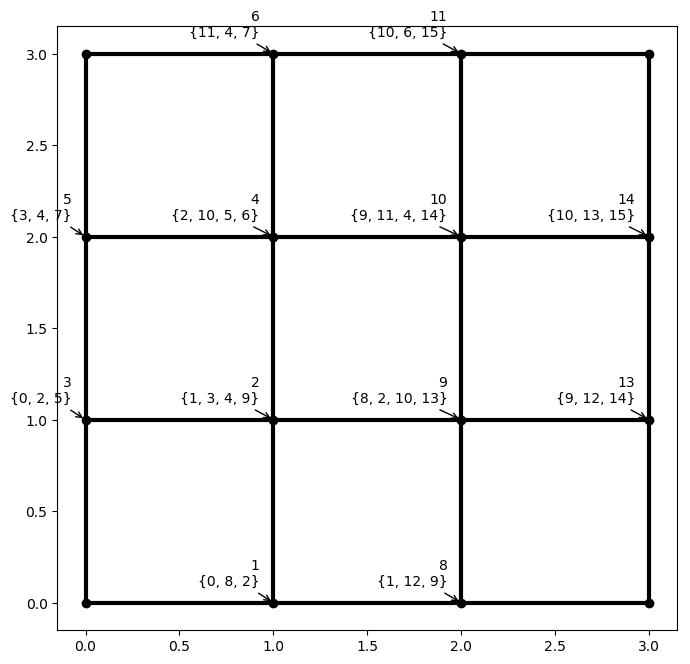

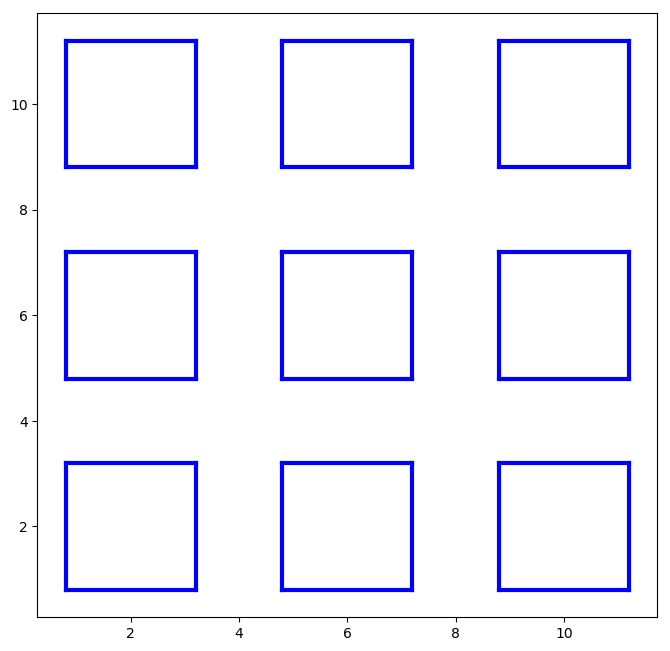

In [13]:
class WorldFactory(Base):

    def roads(self):
        segs = []
        d = 1
        for i in range(3):
            for j in range(3):
                i *= d
                j *= d
                segs.append((vec3(i, j, 0), vec3(i + d, j, 0)))
                segs.append((vec3(i + d, j, 0), vec3(i + d, j + d, 0)))
                segs.append((vec3(i + d, j + d, 0), vec3(i, j + d, 0)))
                segs.append((vec3(i, j + d, 0), vec3(i, j, 0)))
        pg = planargraph(segs=segs)

        f, ax = plot()
        plot_pg(ax, pg)
        
        return pg
        
    def parcels(self, roads):
        eb, ibs = roads.polygon()
        ibs = [loop_offset(ib, 0.2) for ib in ibs]

        f, ax = plot()
        for ib in ibs:
            vec3(4, 4, 1).sclps(ib)
            plot_loop(ax, ib, col='b')
        
        return ibs
    
    def __init__(self, **kws):
        super().__init__(**kws)
        roads = self.roads()
        parcels = self.parcels(roads)
        self.seams = [Seam.l2s(parcel) for parcel in parcels]
    
    def scene(self):
        bf = BuildingDesignFactory
        
        #heights = (1 + np.random.choice(8) for i in range(1000))
        
        #bps = [dict(footprint=seam,
        #            setup=BuildingDesignFactory.simple,
        #            n_layers=h) for seam, h in zip(self.seams, heights)]
        
        #controls = [bf.towering(**bp) for bp in bps]
        
        controls = [bf.from_seam(seam) for seam in self.seams]

        scene = lambda control: BuildingParameterization(control).scene()
        return TForm(children=[scene(control) for control in controls])
    
show(WorldFactory())

In [61]:
def uvseams(self, alpha=(np.pi / 2)):
    seams = set()
    fN = self.face_normals()
    for f, face in self:
        for i, j in slide(face, 2):
            #left  = self.e2f.get((i, j))
            #assert left == f # occurs when topology is imperfect
            right = self.e2f.get((j, i))
            if right is None:
                seams.add((i, j))
            else:
                if near(fN[f].ang(fN[right]), alpha) >= alpha:
                    seams.add((i, j))
    return seams

[vec3(-0.8743, 1.0302, 6.0000), vec3(-2.0011, 0.5332, 6.0000), vec3(-2.1360, -0.5165, 6.0000), vec3(-0.6762, -0.9361, 6.0000), vec3(-0.1228, 0.1006, 5.9500), vec3(0.1848, 0.3534, 5.9500), vec3(-0.1228, 0.1006, 5.9500), vec3(0.0355, 0.3972, 6.0000)]
farts []


AssertionError: 

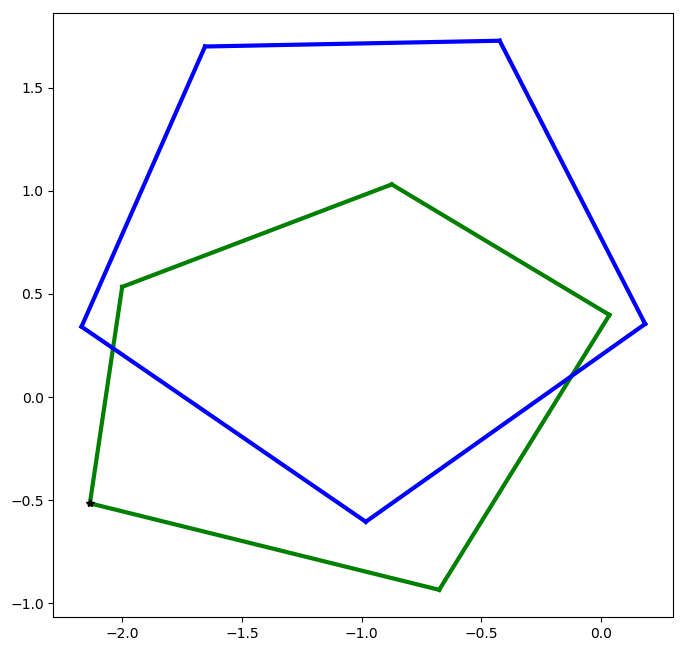

In [74]:
def seamtree():
    
    def cramp(seam, edge):
        control = seam._control()
        u, v = control[edge - 1], control[edge]
        n = (v - u).crs(vec3.Z()).nrm()
        along = [c.dot(n) for c in control]
        dn = n * (-0.1 * (max(along) - min(along)))
        u.trn(dn)
        v.trn(dn)
        return seam
        
    dZ = vec3.Z()
    s  = vec3.U()
    
    base = vec3.U().ring(2, 5)
    base = Seam.l2s(base)

    scene = TForm()
    root = scene.add(TForm(base=base))
    for i in range(5):
        base = cramp(base.cp(), i % 3)
        base = cramp(base.cp(), i % 4 + 1)
        root = root.add(TForm(base=base, t=dZ, q=quat.rotz(np.pi / 8), s=s))
    
    mesh = Mesh()
    patches = []

    def bridges(tf):
            
        above = None
        if tf.children:
            for child in tf.children:
                above = bridges(child)

        if hasattr(tf, 'base'):
            base = tf.transform(tf.base.loop())

            base.reverse()
            
            top = (dZ * 0.95).trnps([p.cp() for p in base])

            patches.append(mesh.bridge(base, top))
            
            if above is not None:
                
                parts = loop_intersection(above, top)
                print('farts', parts)
                assert len(parts) == 1
                
                
                above = [p.cp() for p in above]
                vec3.Z(top[0].z - above[0].z).trnps(above)
                
                upward   = loop_difference(top, above)
                for part in upward:
                    
                    part.reverse()
                    
                    mesh.apy((part, ()))
                
                downward = loop_difference(above, top)
                for part in downward:
                    
                    part.reverse()
                    
                    part.reverse()
                    mesh.apy((part, ()))
            
            else:
                mesh.apy((top, ()))
            
            #mesh.apy((top, ()))
            #mesh.apy((base[::-1], ()))
            
            return base
    
    bridges(scene)
    
    seams = uvseams(mesh)
    mesh.uvs = {}
    for patch in patches:
        mesh.uvs = mesh.unwrap_uvs(f=patch[0], seams=seams, uvs=mesh.uvs)
    
    return mesh
    
mesh = seamtree()
#fuck = seamtree()
show(Base(scene=lambda : TForm(models=[Model(meshes={'generic_0': [mesh]})])), radius=20, target=vec3.Z(10))

In [18]:
base = vec3.U().ring(2, 5)
seam = Seam.l2s(base)
print(seam._closed())
print(seam.cp()._closed())

True
True


# TRASHLINE

In [ ]:
@autotile(1.4, 1.2, 'generic_4')
def doublewindow(rect):
    
    #ww, wh, wz, wd = 0.3, 0.6, 0.2, 0.04
    #wf = WindowFactory(ww, wh, wz, wd)
    #window = wf.scene()
    
    #wall = WallFactory(_loop=rect, ny=1, nx=2).scene()
    wall = WallFactory.scenes(loop=rect, ny=1, nx=None)
    
    return wall
    

loop = [vec3(0, 0, 0), vec3(5, 0, 0), vec3(5, 0, 4.5), vec3(0, 0, 4.5)]
print(loop)

show(Base(scene=lambda : doublewindow(loop)))

In [ ]:
from meshmaker.plt import *
from meshmaker.delaunay import triangulation

#py = ([vec3(1.0000, -1.0000, 4.0000), vec3(1.0000, 1.0000, 4.0000), vec3(-1.0000, 1.0000, 4.0000), vec3(-1.0000, -1.0000, 4.0000)], [[vec3(0.8000, -0.9000, 4.0000), vec3(0.8000, -0.6000, 4.0000), vec3(0.2000, -0.6000, 4.0000), vec3(0.2000, -0.9000, 4.0000)], [vec3(-0.2000, -0.9000, 4.0000), vec3(-0.2000, -0.6000, 4.0000), vec3(-0.8000, -0.6000, 4.0000), vec3(-0.8000, -0.9000, 4.0000)], [vec3(0.8000, -0.4000, 4.0000), vec3(0.8000, -0.1000, 4.0000), vec3(0.2000, -0.1000, 4.0000), vec3(0.2000, -0.4000, 4.0000)], [vec3(-0.2000, -0.4000, 4.0000), vec3(-0.2000, -0.1000, 4.0000), vec3(-0.8000, -0.1000, 4.0000), vec3(-0.8000, -0.4000, 4.0000)], [vec3(0.8000, 0.1000, 4.0000), vec3(0.8000, 0.4000, 4.0000), vec3(0.2000, 0.4000, 4.0000), vec3(0.2000, 0.1000, 4.0000)], [vec3(-0.2000, 0.1000, 4.0000), vec3(-0.2000, 0.4000, 4.0000), vec3(-0.8000, 0.4000, 4.0000), vec3(-0.8000, 0.1000, 4.0000)], [vec3(0.8000, 0.6000, 4.0000), vec3(0.8000, 0.9000, 4.0000), vec3(0.2000, 0.9000, 4.0000), vec3(0.2000, 0.6000, 4.0000)], [vec3(-0.2000, 0.6000, 4.0000), vec3(-0.2000, 0.9000, 4.0000), vec3(-0.8000, 0.9000, 4.0000), vec3(-0.8000, 0.6000, 4.0000)]])
#py = ([vec3(-2.0000, -1.0000, 1.0000), vec3(1.0000, 2.0000, 1.0000), vec3(-1.0000, 2.0000, 1.0000), vec3(-2.0000, 1.0000, 1.0000)], [[vec3(-1.9167, -0.8000, 1.0000), vec3(-1.6167, -0.8000, 1.0000), vec3(-1.6167, -0.2000, 1.0000), vec3(-1.9167, -0.2000, 1.0000)], [vec3(-1.9167, 0.2000, 1.0000), vec3(-1.6167, 0.2000, 1.0000), vec3(-1.6167, 0.8000, 1.0000), vec3(-1.9167, 0.8000, 1.0000)], [vec3(-1.4500, -0.8000, 1.0000), vec3(-1.1500, -0.8000, 1.0000), vec3(-1.1500, -0.2000, 1.0000), vec3(-1.4500, -0.2000, 1.0000)], [vec3(-1.4500, 0.2000, 1.0000), vec3(-1.1500, 0.2000, 1.0000), vec3(-1.1500, 0.8000, 1.0000), vec3(-1.4500, 0.8000, 1.0000)], [vec3(-0.9833, -0.8000, 1.0000), vec3(-0.6833, -0.8000, 1.0000), vec3(-0.6833, -0.2000, 1.0000), vec3(-0.9833, -0.2000, 1.0000)], [vec3(-0.9833, 0.2000, 1.0000), vec3(-0.6833, 0.2000, 1.0000), vec3(-0.6833, 0.8000, 1.0000), vec3(-0.9833, 0.8000, 1.0000)], [vec3(-0.5167, -0.8000, 1.0000), vec3(-0.2167, -0.8000, 1.0000), vec3(-0.2167, -0.2000, 1.0000), vec3(-0.5167, -0.2000, 1.0000)], [vec3(-0.5167, 0.2000, 1.0000), vec3(-0.2167, 0.2000, 1.0000), vec3(-0.2167, 0.8000, 1.0000), vec3(-0.5167, 0.8000, 1.0000)], [vec3(-0.0500, -0.8000, 1.0000), vec3(0.2500, -0.8000, 1.0000), vec3(0.2500, -0.2000, 1.0000), vec3(-0.0500, -0.2000, 1.0000)], [vec3(-0.0500, 0.2000, 1.0000), vec3(0.2500, 0.2000, 1.0000), vec3(0.2500, 0.8000, 1.0000), vec3(-0.0500, 0.8000, 1.0000)], [vec3(0.4167, -0.8000, 1.0000), vec3(0.7167, -0.8000, 1.0000), vec3(0.7167, -0.2000, 1.0000), vec3(0.4167, -0.2000, 1.0000)], [vec3(0.4167, 0.2000, 1.0000), vec3(0.7167, 0.2000, 1.0000), vec3(0.7167, 0.8000, 1.0000), vec3(0.4167, 0.8000, 1.0000)], [vec3(0.8833, -0.8000, 1.0000), vec3(1.1833, -0.8000, 1.0000), vec3(1.1833, -0.2000, 1.0000), vec3(0.8833, -0.2000, 1.0000)], [vec3(0.8833, 0.2000, 1.0000), vec3(1.1833, 0.2000, 1.0000), vec3(1.1833, 0.8000, 1.0000), vec3(0.8833, 0.8000, 1.0000)], [vec3(1.3500, -0.8000, 1.0000), vec3(1.6500, -0.8000, 1.0000), vec3(1.6500, -0.2000, 1.0000), vec3(1.3500, -0.2000, 1.0000)], [vec3(1.3500, 0.2000, 1.0000), vec3(1.6500, 0.2000, 1.0000), vec3(1.6500, 0.8000, 1.0000), vec3(1.3500, 0.8000, 1.0000)], [vec3(1.8167, -0.8000, 1.0000), vec3(2.1167, -0.8000, 1.0000), vec3(2.1167, -0.2000, 1.0000), vec3(1.8167, -0.2000, 1.0000)], [vec3(1.8167, 0.2000, 1.0000), vec3(2.1167, 0.2000, 1.0000), vec3(2.1167, 0.8000, 1.0000), vec3(1.8167, 0.8000, 1.0000)]])
#py = ([vec3(-2.0000, -2.0000, 1.0000), vec3(2.0000, -2.0000, 1.0000), vec3(2.0000, 2.0000, 1.0000), vec3(-2.0000, 2.0000, 1.0000)], [[vec3(-1.9000, -1.6000, 1.0000), vec3(-1.6000, -1.6000, 1.0000), vec3(-1.6000, -1.0000, 1.0000), vec3(-1.9000, -1.0000, 1.0000)], [vec3(-1.9000, -0.6000, 1.0000), vec3(-1.6000, -0.6000, 1.0000), vec3(-1.6000, -0.0000, 1.0000), vec3(-1.9000, -0.0000, 1.0000)], [vec3(-1.9000, 0.4000, 1.0000), vec3(-1.6000, 0.4000, 1.0000), vec3(-1.6000, 1.0000, 1.0000), vec3(-1.9000, 1.0000, 1.0000)], [vec3(-1.9000, 1.4000, 1.0000), vec3(-1.6000, 1.4000, 1.0000), vec3(-1.6000, 2.0000, 1.0000), vec3(-1.9000, 2.0000, 1.0000)], [vec3(-1.4000, -1.6000, 1.0000), vec3(-1.1000, -1.6000, 1.0000), vec3(-1.1000, -1.0000, 1.0000), vec3(-1.4000, -1.0000, 1.0000)], [vec3(-1.4000, -0.6000, 1.0000), vec3(-1.1000, -0.6000, 1.0000), vec3(-1.1000, -0.0000, 1.0000), vec3(-1.4000, -0.0000, 1.0000)], [vec3(-1.4000, 0.4000, 1.0000), vec3(-1.1000, 0.4000, 1.0000), vec3(-1.1000, 1.0000, 1.0000), vec3(-1.4000, 1.0000, 1.0000)], [vec3(-1.4000, 1.4000, 1.0000), vec3(-1.1000, 1.4000, 1.0000), vec3(-1.1000, 2.0000, 1.0000), vec3(-1.4000, 2.0000, 1.0000)], [vec3(-0.9000, -1.6000, 1.0000), vec3(-0.6000, -1.6000, 1.0000), vec3(-0.6000, -1.0000, 1.0000), vec3(-0.9000, -1.0000, 1.0000)], [vec3(-0.9000, -0.6000, 1.0000), vec3(-0.6000, -0.6000, 1.0000), vec3(-0.6000, -0.0000, 1.0000), vec3(-0.9000, -0.0000, 1.0000)], [vec3(-0.9000, 0.4000, 1.0000), vec3(-0.6000, 0.4000, 1.0000), vec3(-0.6000, 1.0000, 1.0000), vec3(-0.9000, 1.0000, 1.0000)], [vec3(-0.9000, 1.4000, 1.0000), vec3(-0.6000, 1.4000, 1.0000), vec3(-0.6000, 2.0000, 1.0000), vec3(-0.9000, 2.0000, 1.0000)], [vec3(-0.4000, -1.6000, 1.0000), vec3(-0.1000, -1.6000, 1.0000), vec3(-0.1000, -1.0000, 1.0000), vec3(-0.4000, -1.0000, 1.0000)], [vec3(-0.4000, -0.6000, 1.0000), vec3(-0.1000, -0.6000, 1.0000), vec3(-0.1000, -0.0000, 1.0000), vec3(-0.4000, -0.0000, 1.0000)], [vec3(-0.4000, 0.4000, 1.0000), vec3(-0.1000, 0.4000, 1.0000), vec3(-0.1000, 1.0000, 1.0000), vec3(-0.4000, 1.0000, 1.0000)], [vec3(-0.4000, 1.4000, 1.0000), vec3(-0.1000, 1.4000, 1.0000), vec3(-0.1000, 2.0000, 1.0000), vec3(-0.4000, 2.0000, 1.0000)], [vec3(0.1000, -1.6000, 1.0000), vec3(0.4000, -1.6000, 1.0000), vec3(0.4000, -1.0000, 1.0000), vec3(0.1000, -1.0000, 1.0000)], [vec3(0.1000, -0.6000, 1.0000), vec3(0.4000, -0.6000, 1.0000), vec3(0.4000, -0.0000, 1.0000), vec3(0.1000, -0.0000, 1.0000)], [vec3(0.1000, 0.4000, 1.0000), vec3(0.4000, 0.4000, 1.0000), vec3(0.4000, 1.0000, 1.0000), vec3(0.1000, 1.0000, 1.0000)], [vec3(0.1000, 1.4000, 1.0000), vec3(0.4000, 1.4000, 1.0000), vec3(0.4000, 2.0000, 1.0000), vec3(0.1000, 2.0000, 1.0000)], [vec3(0.6000, -1.6000, 1.0000), vec3(0.9000, -1.6000, 1.0000), vec3(0.9000, -1.0000, 1.0000), vec3(0.6000, -1.0000, 1.0000)], [vec3(0.6000, -0.6000, 1.0000), vec3(0.9000, -0.6000, 1.0000), vec3(0.9000, -0.0000, 1.0000), vec3(0.6000, -0.0000, 1.0000)], [vec3(0.6000, 0.4000, 1.0000), vec3(0.9000, 0.4000, 1.0000), vec3(0.9000, 1.0000, 1.0000), vec3(0.6000, 1.0000, 1.0000)], [vec3(0.6000, 1.4000, 1.0000), vec3(0.9000, 1.4000, 1.0000), vec3(0.9000, 2.0000, 1.0000), vec3(0.6000, 2.0000, 1.0000)], [vec3(1.1000, -1.6000, 1.0000), vec3(1.4000, -1.6000, 1.0000), vec3(1.4000, -1.0000, 1.0000), vec3(1.1000, -1.0000, 1.0000)], [vec3(1.1000, -0.6000, 1.0000), vec3(1.4000, -0.6000, 1.0000), vec3(1.4000, -0.0000, 1.0000), vec3(1.1000, -0.0000, 1.0000)], [vec3(1.1000, 0.4000, 1.0000), vec3(1.4000, 0.4000, 1.0000), vec3(1.4000, 1.0000, 1.0000), vec3(1.1000, 1.0000, 1.0000)], [vec3(1.1000, 1.4000, 1.0000), vec3(1.4000, 1.4000, 1.0000), vec3(1.4000, 2.0000, 1.0000), vec3(1.1000, 2.0000, 1.0000)], [vec3(1.6000, -1.6000, 1.0000), vec3(1.9000, -1.6000, 1.0000), vec3(1.9000, -1.0000, 1.0000), vec3(1.6000, -1.0000, 1.0000)], [vec3(1.6000, -0.6000, 1.0000), vec3(1.9000, -0.6000, 1.0000), vec3(1.9000, -0.0000, 1.0000), vec3(1.6000, -0.0000, 1.0000)], [vec3(1.6000, 0.4000, 1.0000), vec3(1.9000, 0.4000, 1.0000), vec3(1.9000, 1.0000, 1.0000), vec3(1.6000, 1.0000, 1.0000)], [vec3(1.6000, 1.4000, 1.0000), vec3(1.9000, 1.4000, 1.0000), vec3(1.9000, 2.0000, 1.0000), vec3(1.6000, 2.0000, 1.0000)]])
#py = ([vec3(-1.0000, 1.0000, -8.0000), vec3(-1.0000, -1.0000, -8.0000), vec3(-1.0000, -1.0000, 8.0000), vec3(-1.0000, 1.0000, 8.0000)], [[vec3(-1.0000, 0.9500, -7.9000), vec3(-1.0000, 0.6500, -7.9000), vec3(-1.0000, 0.6500, -7.3000), vec3(-1.0000, 0.9500, -7.3000)], [vec3(-1.0000, 0.9500, -6.9000), vec3(-1.0000, 0.6500, -6.9000), vec3(-1.0000, 0.6500, -6.3000), vec3(-1.0000, 0.9500, -6.3000)], [vec3(-1.0000, 0.9500, -5.9000), vec3(-1.0000, 0.6500, -5.9000), vec3(-1.0000, 0.6500, -5.3000), vec3(-1.0000, 0.9500, -5.3000)], [vec3(-1.0000, 0.9500, -4.9000), vec3(-1.0000, 0.6500, -4.9000), vec3(-1.0000, 0.6500, -4.3000), vec3(-1.0000, 0.9500, -4.3000)], [vec3(-1.0000, 0.9500, -3.9000), vec3(-1.0000, 0.6500, -3.9000), vec3(-1.0000, 0.6500, -3.3000), vec3(-1.0000, 0.9500, -3.3000)], [vec3(-1.0000, 0.9500, -2.9000), vec3(-1.0000, 0.6500, -2.9000), vec3(-1.0000, 0.6500, -2.3000), vec3(-1.0000, 0.9500, -2.3000)], [vec3(-1.0000, 0.9500, -1.9000), vec3(-1.0000, 0.6500, -1.9000), vec3(-1.0000, 0.6500, -1.3000), vec3(-1.0000, 0.9500, -1.3000)], [vec3(-1.0000, 0.9500, -0.9000), vec3(-1.0000, 0.6500, -0.9000), vec3(-1.0000, 0.6500, -0.3000), vec3(-1.0000, 0.9500, -0.3000)], [vec3(-1.0000, 0.9500, 0.1000), vec3(-1.0000, 0.6500, 0.1000), vec3(-1.0000, 0.6500, 0.7000), vec3(-1.0000, 0.9500, 0.7000)], [vec3(-1.0000, 0.9500, 1.1000), vec3(-1.0000, 0.6500, 1.1000), vec3(-1.0000, 0.6500, 1.7000), vec3(-1.0000, 0.9500, 1.7000)], [vec3(-1.0000, 0.9500, 2.1000), vec3(-1.0000, 0.6500, 2.1000), vec3(-1.0000, 0.6500, 2.7000), vec3(-1.0000, 0.9500, 2.7000)], [vec3(-1.0000, 0.9500, 3.1000), vec3(-1.0000, 0.6500, 3.1000), vec3(-1.0000, 0.6500, 3.7000), vec3(-1.0000, 0.9500, 3.7000)], [vec3(-1.0000, 0.9500, 4.1000), vec3(-1.0000, 0.6500, 4.1000), vec3(-1.0000, 0.6500, 4.7000), vec3(-1.0000, 0.9500, 4.7000)], [vec3(-1.0000, 0.9500, 5.1000), vec3(-1.0000, 0.6500, 5.1000), vec3(-1.0000, 0.6500, 5.7000), vec3(-1.0000, 0.9500, 5.7000)], [vec3(-1.0000, 0.9500, 6.1000), vec3(-1.0000, 0.6500, 6.1000), vec3(-1.0000, 0.6500, 6.7000), vec3(-1.0000, 0.9500, 6.7000)], [vec3(-1.0000, 0.9500, 7.1000), vec3(-1.0000, 0.6500, 7.1000), vec3(-1.0000, 0.6500, 7.7000), vec3(-1.0000, 0.9500, 7.7000)], [vec3(-1.0000, 0.5500, -7.9000), vec3(-1.0000, 0.2500, -7.9000), vec3(-1.0000, 0.2500, -7.3000), vec3(-1.0000, 0.5500, -7.3000)], [vec3(-1.0000, 0.5500, -6.9000), vec3(-1.0000, 0.2500, -6.9000), vec3(-1.0000, 0.2500, -6.3000), vec3(-1.0000, 0.5500, -6.3000)], [vec3(-1.0000, 0.5500, -5.9000), vec3(-1.0000, 0.2500, -5.9000), vec3(-1.0000, 0.2500, -5.3000), vec3(-1.0000, 0.5500, -5.3000)], [vec3(-1.0000, 0.5500, -4.9000), vec3(-1.0000, 0.2500, -4.9000), vec3(-1.0000, 0.2500, -4.3000), vec3(-1.0000, 0.5500, -4.3000)], [vec3(-1.0000, 0.5500, -3.9000), vec3(-1.0000, 0.2500, -3.9000), vec3(-1.0000, 0.2500, -3.3000), vec3(-1.0000, 0.5500, -3.3000)], [vec3(-1.0000, 0.5500, -2.9000), vec3(-1.0000, 0.2500, -2.9000), vec3(-1.0000, 0.2500, -2.3000), vec3(-1.0000, 0.5500, -2.3000)], [vec3(-1.0000, 0.5500, -1.9000), vec3(-1.0000, 0.2500, -1.9000), vec3(-1.0000, 0.2500, -1.3000), vec3(-1.0000, 0.5500, -1.3000)], [vec3(-1.0000, 0.5500, -0.9000), vec3(-1.0000, 0.2500, -0.9000), vec3(-1.0000, 0.2500, -0.3000), vec3(-1.0000, 0.5500, -0.3000)], [vec3(-1.0000, 0.5500, 0.1000), vec3(-1.0000, 0.2500, 0.1000), vec3(-1.0000, 0.2500, 0.7000), vec3(-1.0000, 0.5500, 0.7000)], [vec3(-1.0000, 0.5500, 1.1000), vec3(-1.0000, 0.2500, 1.1000), vec3(-1.0000, 0.2500, 1.7000), vec3(-1.0000, 0.5500, 1.7000)], [vec3(-1.0000, 0.5500, 2.1000), vec3(-1.0000, 0.2500, 2.1000), vec3(-1.0000, 0.2500, 2.7000), vec3(-1.0000, 0.5500, 2.7000)], [vec3(-1.0000, 0.5500, 3.1000), vec3(-1.0000, 0.2500, 3.1000), vec3(-1.0000, 0.2500, 3.7000), vec3(-1.0000, 0.5500, 3.7000)], [vec3(-1.0000, 0.5500, 4.1000), vec3(-1.0000, 0.2500, 4.1000), vec3(-1.0000, 0.2500, 4.7000), vec3(-1.0000, 0.5500, 4.7000)], [vec3(-1.0000, 0.5500, 5.1000), vec3(-1.0000, 0.2500, 5.1000), vec3(-1.0000, 0.2500, 5.7000), vec3(-1.0000, 0.5500, 5.7000)], [vec3(-1.0000, 0.5500, 6.1000), vec3(-1.0000, 0.2500, 6.1000), vec3(-1.0000, 0.2500, 6.7000), vec3(-1.0000, 0.5500, 6.7000)], [vec3(-1.0000, 0.5500, 7.1000), vec3(-1.0000, 0.2500, 7.1000), vec3(-1.0000, 0.2500, 7.7000), vec3(-1.0000, 0.5500, 7.7000)], [vec3(-1.0000, 0.1500, -7.9000), vec3(-1.0000, -0.1500, -7.9000), vec3(-1.0000, -0.1500, -7.3000), vec3(-1.0000, 0.1500, -7.3000)], [vec3(-1.0000, 0.1500, -6.9000), vec3(-1.0000, -0.1500, -6.9000), vec3(-1.0000, -0.1500, -6.3000), vec3(-1.0000, 0.1500, -6.3000)], [vec3(-1.0000, 0.1500, -5.9000), vec3(-1.0000, -0.1500, -5.9000), vec3(-1.0000, -0.1500, -5.3000), vec3(-1.0000, 0.1500, -5.3000)], [vec3(-1.0000, 0.1500, -4.9000), vec3(-1.0000, -0.1500, -4.9000), vec3(-1.0000, -0.1500, -4.3000), vec3(-1.0000, 0.1500, -4.3000)], [vec3(-1.0000, 0.1500, -3.9000), vec3(-1.0000, -0.1500, -3.9000), vec3(-1.0000, -0.1500, -3.3000), vec3(-1.0000, 0.1500, -3.3000)], [vec3(-1.0000, 0.1500, -2.9000), vec3(-1.0000, -0.1500, -2.9000), vec3(-1.0000, -0.1500, -2.3000), vec3(-1.0000, 0.1500, -2.3000)], [vec3(-1.0000, 0.1500, -1.9000), vec3(-1.0000, -0.1500, -1.9000), vec3(-1.0000, -0.1500, -1.3000), vec3(-1.0000, 0.1500, -1.3000)], [vec3(-1.0000, 0.1500, -0.9000), vec3(-1.0000, -0.1500, -0.9000), vec3(-1.0000, -0.1500, -0.3000), vec3(-1.0000, 0.1500, -0.3000)], [vec3(-1.0000, 0.1500, 0.1000), vec3(-1.0000, -0.1500, 0.1000), vec3(-1.0000, -0.1500, 0.7000), vec3(-1.0000, 0.1500, 0.7000)], [vec3(-1.0000, 0.1500, 1.1000), vec3(-1.0000, -0.1500, 1.1000), vec3(-1.0000, -0.1500, 1.7000), vec3(-1.0000, 0.1500, 1.7000)], [vec3(-1.0000, 0.1500, 2.1000), vec3(-1.0000, -0.1500, 2.1000), vec3(-1.0000, -0.1500, 2.7000), vec3(-1.0000, 0.1500, 2.7000)], [vec3(-1.0000, 0.1500, 3.1000), vec3(-1.0000, -0.1500, 3.1000), vec3(-1.0000, -0.1500, 3.7000), vec3(-1.0000, 0.1500, 3.7000)], [vec3(-1.0000, 0.1500, 4.1000), vec3(-1.0000, -0.1500, 4.1000), vec3(-1.0000, -0.1500, 4.7000), vec3(-1.0000, 0.1500, 4.7000)], [vec3(-1.0000, 0.1500, 5.1000), vec3(-1.0000, -0.1500, 5.1000), vec3(-1.0000, -0.1500, 5.7000), vec3(-1.0000, 0.1500, 5.7000)], [vec3(-1.0000, 0.1500, 6.1000), vec3(-1.0000, -0.1500, 6.1000), vec3(-1.0000, -0.1500, 6.7000), vec3(-1.0000, 0.1500, 6.7000)], [vec3(-1.0000, 0.1500, 7.1000), vec3(-1.0000, -0.1500, 7.1000), vec3(-1.0000, -0.1500, 7.7000), vec3(-1.0000, 0.1500, 7.7000)], [vec3(-1.0000, -0.2500, -7.9000), vec3(-1.0000, -0.5500, -7.9000), vec3(-1.0000, -0.5500, -7.3000), vec3(-1.0000, -0.2500, -7.3000)], [vec3(-1.0000, -0.2500, -6.9000), vec3(-1.0000, -0.5500, -6.9000), vec3(-1.0000, -0.5500, -6.3000), vec3(-1.0000, -0.2500, -6.3000)], [vec3(-1.0000, -0.2500, -5.9000), vec3(-1.0000, -0.5500, -5.9000), vec3(-1.0000, -0.5500, -5.3000), vec3(-1.0000, -0.2500, -5.3000)], [vec3(-1.0000, -0.2500, -4.9000), vec3(-1.0000, -0.5500, -4.9000), vec3(-1.0000, -0.5500, -4.3000), vec3(-1.0000, -0.2500, -4.3000)], [vec3(-1.0000, -0.2500, -3.9000), vec3(-1.0000, -0.5500, -3.9000), vec3(-1.0000, -0.5500, -3.3000), vec3(-1.0000, -0.2500, -3.3000)], [vec3(-1.0000, -0.2500, -2.9000), vec3(-1.0000, -0.5500, -2.9000), vec3(-1.0000, -0.5500, -2.3000), vec3(-1.0000, -0.2500, -2.3000)], [vec3(-1.0000, -0.2500, -1.9000), vec3(-1.0000, -0.5500, -1.9000), vec3(-1.0000, -0.5500, -1.3000), vec3(-1.0000, -0.2500, -1.3000)], [vec3(-1.0000, -0.2500, -0.9000), vec3(-1.0000, -0.5500, -0.9000), vec3(-1.0000, -0.5500, -0.3000), vec3(-1.0000, -0.2500, -0.3000)], [vec3(-1.0000, -0.2500, 0.1000), vec3(-1.0000, -0.5500, 0.1000), vec3(-1.0000, -0.5500, 0.7000), vec3(-1.0000, -0.2500, 0.7000)], [vec3(-1.0000, -0.2500, 1.1000), vec3(-1.0000, -0.5500, 1.1000), vec3(-1.0000, -0.5500, 1.7000), vec3(-1.0000, -0.2500, 1.7000)], [vec3(-1.0000, -0.2500, 2.1000), vec3(-1.0000, -0.5500, 2.1000), vec3(-1.0000, -0.5500, 2.7000), vec3(-1.0000, -0.2500, 2.7000)], [vec3(-1.0000, -0.2500, 3.1000), vec3(-1.0000, -0.5500, 3.1000), vec3(-1.0000, -0.5500, 3.7000), vec3(-1.0000, -0.2500, 3.7000)], [vec3(-1.0000, -0.2500, 4.1000), vec3(-1.0000, -0.5500, 4.1000), vec3(-1.0000, -0.5500, 4.7000), vec3(-1.0000, -0.2500, 4.7000)], [vec3(-1.0000, -0.2500, 5.1000), vec3(-1.0000, -0.5500, 5.1000), vec3(-1.0000, -0.5500, 5.7000), vec3(-1.0000, -0.2500, 5.7000)], [vec3(-1.0000, -0.2500, 6.1000), vec3(-1.0000, -0.5500, 6.1000), vec3(-1.0000, -0.5500, 6.7000), vec3(-1.0000, -0.2500, 6.7000)], [vec3(-1.0000, -0.2500, 7.1000), vec3(-1.0000, -0.5500, 7.1000), vec3(-1.0000, -0.5500, 7.7000), vec3(-1.0000, -0.2500, 7.7000)], [vec3(-1.0000, -0.6500, -7.9000), vec3(-1.0000, -0.9500, -7.9000), vec3(-1.0000, -0.9500, -7.3000), vec3(-1.0000, -0.6500, -7.3000)], [vec3(-1.0000, -0.6500, -6.9000), vec3(-1.0000, -0.9500, -6.9000), vec3(-1.0000, -0.9500, -6.3000), vec3(-1.0000, -0.6500, -6.3000)], [vec3(-1.0000, -0.6500, -5.9000), vec3(-1.0000, -0.9500, -5.9000), vec3(-1.0000, -0.9500, -5.3000), vec3(-1.0000, -0.6500, -5.3000)], [vec3(-1.0000, -0.6500, -4.9000), vec3(-1.0000, -0.9500, -4.9000), vec3(-1.0000, -0.9500, -4.3000), vec3(-1.0000, -0.6500, -4.3000)], [vec3(-1.0000, -0.6500, -3.9000), vec3(-1.0000, -0.9500, -3.9000), vec3(-1.0000, -0.9500, -3.3000), vec3(-1.0000, -0.6500, -3.3000)], [vec3(-1.0000, -0.6500, -2.9000), vec3(-1.0000, -0.9500, -2.9000), vec3(-1.0000, -0.9500, -2.3000), vec3(-1.0000, -0.6500, -2.3000)], [vec3(-1.0000, -0.6500, -1.9000), vec3(-1.0000, -0.9500, -1.9000), vec3(-1.0000, -0.9500, -1.3000), vec3(-1.0000, -0.6500, -1.3000)], [vec3(-1.0000, -0.6500, -0.9000), vec3(-1.0000, -0.9500, -0.9000), vec3(-1.0000, -0.9500, -0.3000), vec3(-1.0000, -0.6500, -0.3000)], [vec3(-1.0000, -0.6500, 0.1000), vec3(-1.0000, -0.9500, 0.1000), vec3(-1.0000, -0.9500, 0.7000), vec3(-1.0000, -0.6500, 0.7000)], [vec3(-1.0000, -0.6500, 1.1000), vec3(-1.0000, -0.9500, 1.1000), vec3(-1.0000, -0.9500, 1.7000), vec3(-1.0000, -0.6500, 1.7000)], [vec3(-1.0000, -0.6500, 2.1000), vec3(-1.0000, -0.9500, 2.1000), vec3(-1.0000, -0.9500, 2.7000), vec3(-1.0000, -0.6500, 2.7000)], [vec3(-1.0000, -0.6500, 3.1000), vec3(-1.0000, -0.9500, 3.1000), vec3(-1.0000, -0.9500, 3.7000), vec3(-1.0000, -0.6500, 3.7000)], [vec3(-1.0000, -0.6500, 4.1000), vec3(-1.0000, -0.9500, 4.1000), vec3(-1.0000, -0.9500, 4.7000), vec3(-1.0000, -0.6500, 4.7000)], [vec3(-1.0000, -0.6500, 5.1000), vec3(-1.0000, -0.9500, 5.1000), vec3(-1.0000, -0.9500, 5.7000), vec3(-1.0000, -0.6500, 5.7000)], [vec3(-1.0000, -0.6500, 6.1000), vec3(-1.0000, -0.9500, 6.1000), vec3(-1.0000, -0.9500, 6.7000), vec3(-1.0000, -0.6500, 6.7000)], [vec3(-1.0000, -0.6500, 7.1000), vec3(-1.0000, -0.9500, 7.1000), vec3(-1.0000, -0.9500, 7.7000), vec3(-1.0000, -0.6500, 7.7000)]])
#py = ([vec3(-0.1300, 0.0000, 0.2200), vec3(0.1300, 0.0000, 0.2200), vec3(0.1300, 0.0000, 0.7865), vec3(0.0705, -0.0000, 0.8103), vec3(-0.0000, -0.0000, 0.8150), vec3(-0.0705, -0.0000, 0.8103), vec3(-0.1300, -0.0000, 0.7865)], ())
py = ([vec3(0.0000, 0.0000, 0.0000), vec3(1.4000, 0.0000, 0.0000), vec3(1.4000, 0.0000, 1.2000), vec3(0.0000, 0.0000, 1.2000)], [[vec3(0.0500, 0.0000, 0.4000), vec3(0.6500, 0.0000, 0.4000), vec3(0.6500, 0.0000, 0.8000), vec3(0.5000, 0.0000, 0.8300), vec3(0.3500, 0.0000, 0.8350), vec3(0.2000, 0.0000, 0.8300), vec3(0.0500, 0.0000, 0.8000)], [vec3(0.7500, 0.0000, 0.4000), vec3(1.3500, 0.0000, 0.4000), vec3(1.3500, 0.0000, 0.8000), vec3(1.2000, 0.0000, 0.8300), vec3(1.0500, 0.0000, 0.8350), vec3(0.9000, 0.0000, 0.8300), vec3(0.7500, 0.0000, 0.8000)]])

q = quat.av(-np.pi / 2, vec3.X())

q.rot(py[0])
for ib in py[1]:
    q.rot(ib)

f, ax = plot()

plot_loop(ax, py[0], col='g')
for ib in py[1]:
    plot_loop(ax, ib, col='b')

t = triangulation(py, 0.00001, None, 10000)
t.plot(ax)

In [ ]:
class Roof(Base):
    
    __name__ = 'FuckingRoof'
    
    def __init__(self, texture='generic_8', **kws):
        super().__init__(**kws)
        self.texture = texture
        
    def __call__(self, control, faces):
        mesh = Mesh()
        
        seams = control.perimeter(faces)
        
        control._face_normals = None
        normals = control.face_normals()
        cliffs = []
        for seam in seams:
            cliff = []
            for i, j in seam:
                inside  = control.e2f.get((i, j))
                outside = control.e2f.get((j, i))
                if near(normals[inside].z - normals[outside].z, 0) > 0:
                    inside = [control.vertices[v] for v in control.faces[inside]]
                    outside = [control.vertices[v] for v in control.faces[outside]]
                    inside_z = vec3.com(inside).z
                    outside_z = vec3.com(outside).z
                    if inside_z > outside_z:
                        cliff.append((i, j))
            else:
                if cliff:
                    cliffs.append(cliff)

        rims = [self.cliffrailing(control, cliff) for cliff in cliffs]
        
        for f in faces:
            mesh.af([control.vertices[v] for v in control.faces[f]])
        return TForm(models=[Model(meshes={self.texture: [mesh]})], children=rims)

    def cliffrailing(self, control, cliff, w=0.02, h=0.2):
        complete = cliff[0][0] == cliff[-1][1]
        loop = [control.vertices[i] for i, j in cliff]
        if not complete:
            loop.append(control.vertices[cliff[-1][1]])

        loops = [loop]
        loops.append([p.cp().ztrn( h) for p in loops[-1]])
        loops.append(loop_offset(loops[-1], w, complete))
        loops.append([p.cp().ztrn(-h) for p in loops[-1]])
        
        mesh = Mesh()
        mesh.bridges(loops, m=1, n=(0 if complete else 1))
        mesh.uvs = mesh.unwrap_uvs(Y=vec3.Z())
        return TForm(models=[Model(meshes={self.texture: [mesh]})])

In [ ]:
def jamb(loop, jw=0.02, jd=0.04, texture='generic_10'):
    """Hide the edges of loop with a mesh"""
    N = loop_normal(loop)
    loops = []
    loops.append((N * (jd / 2)).trnps([p.cp() for p in loop]))
    loops.append(loop_offset(loops[-1], jw))
    loops.append((N * (-jd)).trnps([p.cp() for p in loops[-1]]))
    loops.append(loop_offset(loops[-1], -jw))
    mesh = Mesh()
    mesh.bridges(loops, n=0, m=1)
    return TForm(models=[Model(meshes={texture: [mesh]})])        

In [ ]:
class Entry(Base):

    __name__ = 'AnalEntry'

    def __init__(self, **kws):
        super().__init__(**kws)
        self.textures = {'wall': 'generic_1', 'stairs': 'generic_8', 'jamb': 'generic_10'}
        
    def __call__(self, control, faces):
        return TForm(children=[self.door(control, f) for f in faces])
    
    def door(self, control, f):
        dw, dh, dz, dd = 0.3, 0.6, 0.02, 0.04
        
        loop = [control.vertices[v] for v in control.faces[f]]
        o = loopO(loop)
        w = loop[o + 1].d(loop[o])
        h = loop[o - 1].d(loop[o])
        dw = min(dw, 0.8 * w)
        dh = min(dh, 0.8 * h - dz)
        T = (loop[o + 1] - loop[o]).nrm()
        Z = (loop[o - 1] - loop[o]).nrm()
        x = loop[o].lerp(loop[o + 1], 0.5)
        a = x - T * (dw / 2) + Z * dz
        b = a + T * (dw)
        w, z = b + Z * dh, a + Z * dh

        N = control.face_normals()[f]
        loops = [loop[o + 1:] + loop[:o + 1], [b, w, z, a]]
        loops.append([p - N * dd for p in loops[-1]])
        
        mesh = Mesh()
        mesh.bridges(loops, m=1)
        #mesh.bridge(loop[o + 1:] + loop[:o + 1], [b, w, z, a])
        #mesh.af(loops[-1])
        
        stoop = self.access(x, control, control.faces[f][o], control.faces[f][o + 1])
        thejamb = jamb(loops[-1], texture=self.textures['jamb'])
        
        return TForm(models=[Model(meshes={self.textures['wall']: [mesh]})],
                     children=[stoop, thejamb])
        
    def access(self, anchor, control, i, j):
        """Find a sequence of faces with sufficient steepness along edgeloop ji"""
        edges = control.edgeloop(i, j)
        edges.pop(0)

        height = 0
        direction = vec3.Z().crs(control.vertices[i] - control.vertices[j]).nrm()
        for i, j in edges:
            f = control.e2f.get((i, j))
            N = control.face_normals()[f]
            zs = [control.vertices[v].z for v in control.faces[f]]
            height += max(zs) - min(zs)
            if N.z > 0:
                break
        
        slope = 1.0
        sw = 0.5
        loop = []
        loop.append(anchor + vec3.nZ(height) + direction * (height / slope))
        loop.append(anchor.cp())
        loop.append(anchor.cp().ztrn(-height))

        N = loop_normal(loop)
        l = [(p + N * (sw / 2)) for p in loop]
        r = [(p - N * (sw / 2)) for p in loop]
        
        mesh = Mesh()
        mesh.af(l)
        mesh.af(r[::-1])
        patch = mesh.bridge(r, l, m=2)
        mesh.uvs = mesh.unwrap_uvs(patch[0])
        
        return TForm(models=[Model(meshes={self.textures['stairs']: [mesh]})])

In [ ]:
def make_control_mesh():
    Z = vec3.Z()
    
    mesh = Mesh()
    
    grass = MetaMesh.textured('generic_0')
    tile = MetaMesh.textured('generic_1')
    foundation = MetaMesh.textured('generic_2')

    wall = Wall(m=0)
    roof = Roof()
    entry = Entry()
    
    r = 2.5
    bottom = [vec3(-r,-r, 0), vec3( r,-r, 0), vec3( r, r, 0), vec3(-r, r, 0)]
    mesh.grid(*bottom, 4, 4, meta=grass)
    
    footprint = []
    for f, face in mesh:
        if all((mesh.e2f.get((j, i)) is not None) for i, j in slide(face, 2)):
            footprint.append(f)
            mesh.meta[f] = foundation
    
    #footprint.pop(-1)
    patches = mesh.extrude(footprint, Z * 0.2)
    for f in patches[0]:
        mesh.meta[f] = roof
            
    patches = mesh.extrude(patches[0], Z)
    for f in patches[1]:
        mesh.meta[f] = tile
    mesh.meta[patches[1][-5]] = entry
    
    patches[0].pop(-1)
    patches[0].pop(-2)
    patches = mesh.extrude(patches[0], Z)
    for f in patches[1]:
        mesh.meta[f] = wall
    
    patches[0].pop(-2)
    patches = mesh.extrude(patches[0], Z)
    for f in patches[1]:
        mesh.meta[f] = wall

    patches = mesh.extrude(patches[0], Z)
    for f in patches[1]:
        mesh.meta[f] = wall
        
    mesh.uvs = mesh.unwrap_uvs()

    return mesh
    

def test():
    GLWindow(MetaMesh(make_control_mesh()), '../resources/textures')
    
test()

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -T lprof0 -f Wall.__call__ test()

In [ ]:
class ColumnFactory(Base):
    
    @classmethod
    def meta(cls):
        """"""
        control = Mesh()
        #tile = MetaMesh.textured('tile2')
        tile = MetaMesh.textured('generic_9')
        #wood = MetaMesh.textured('wood2')
        wood = MetaMesh.textured('generic_2')

        r, h = 1, 1
        bottom = [vec3(-r,-r, 0), vec3( r,-r, 0), vec3( r, r, 0), vec3(-r, r, 0)]
        top = [p.cp().ztrn(h) for p in bottom]
        
        control.grid(*bottom, 2, 2, meta=(cls.simple, tile))
        control.bridge(top, bottom, meta=tile)
        return MetaMesh(control)
    
    @staticmethod
    def column(r=0.1, n=16, h=1, texture='generic_0'):
        b = vec3.Z(0).ring(r, n)
        t = vec3.Z(h).ring(r, n)
        mesh = Mesh()
        mesh.bridge(b, t, m=0, e=0.00001)
        mesh.normals = mesh.vertex_normals(smooth=True)
        mesh.uvs = mesh.unwrap_uvs(Y=vec3.Z(), S=vec3(1, 1, 0))
        return [Model(meshes={texture: [mesh]})]
    
    @classmethod
    def simple(cls, control, faces):
        models = cls.column()
        columns = []
        vertices = set([v for f in faces for v in control.faces[f]])
        for v in vertices:
            p = control.vertices[v].cp()
            columns.append(TForm(t=p, models=models))
        return TForm(children=columns)


GLWindow(ColumnFactory.meta(), '../resources/textures')

In [15]:
def test(r=2, fh=0.5, lh=1.0):
    gen0 = MetaMesh.textured('generic_0')
    gen3 = MetaMesh.textured('generic_3')
    gen6 = MetaMesh.textured('generic_6')
    roof = Roof('generic_8')
    entry = Entry()
    
    
    control = Mesh()
    
    bottom = [vec3(-r,-r, 0), vec3( r,-r, 0), vec3( r, r, 0), vec3(-r, r, 0)]
    patch = control.grid(*bottom, 4, 4, meta=gen0)
    
    facade = patch[0] + patch[1]
    facade = control.extrude(facade, vec3.Z(fh), meta=gen3)
    
    facade = control.extrude(facade[0], vec3.Z(lh), meta=gen6)

    for f in facade[1]:
        N = control.face_normals()[f]
        if near(N.x, 0) > 0:
            control.meta[f] = entry
    
    for f in facade[0]:
        control.meta[f] = roof
    
    control.uvs = control.unwrap_uvs()
    
    GLWindow(MetaMesh(control), '../resources/textures')
    
test()

NameError: name 'Roof' is not defined

In [ ]:
def test():
    mesh = Mesh()
        
    du, dv = vec3(.1, 0, 0), vec3(0, -.1, 0)
    s2 = Seam(vec3(1, 3, 0), vec3(0.1, 3, 0), du=dv.fp(), dv=du, n=4)
    s1 = Seam(vec3(0.1, 0, 0), vec3(1, 3, 0), du=du, dv=dv, n=5, next=s2)
    
    s = list(s1)
    
    mesh.revolve(s, vec3.Y(), n=16)
    mesh.uvs = mesh.unwrap_uvs()
    mesh.normals = mesh.vertex_normals(smooth=True)
    return TForm(models=[Model(meshes={'generic_0': [mesh]})])
    
show(Base(scene=lambda : test()))

In [ ]:
def chunkloop(loop, chunk_w=1.01, chunk_h=1.01, n=None, m=None):
    """Chunk a rectangular space into a grid"""
    o = loopO(loop)
    loop = loop[o:] + loop[:o]    
    lw = round(loop[0].d(loop[ 1]), 1)
    lh = round(loop[0].d(loop[-1]), 1)
    n = (int(lw / chunk_w) - 1) if n is None else n
    m = (int(lh / chunk_h) - 1) if m is None else m
    bottom = ([loop[0]] + loop[0].line(loop[1], n) + [loop[1]])
    top    = ([loop[3]] + loop[3].line(loop[2], n) + [loop[2]])
    lines  = [([x] + x.line(y, m) + [y]) for x, y in zip(bottom, top)]
    chunks = []
    for l, r in slide(lines, 2, 1):
        for (a, b), (c, d) in zip(slide(l, 2, 1), slide(r, 2, 1)):
            chunk = [a, c, d, b]
            chunks.append(chunk)
    return chunks, lw, lh

def test():
    from meshmaker.plt import plot, plot_loop
    
    l = vec3.O().ring(0.2, 4, False)
    
    f, ax = plot()
    plot_loop(ax, l, col='r', lw=2, mk='*')
    for l in chunkloop(l)[0]:
        plot_loop(ax, loop_offset(l, 0.1), col='b', lw=1, mk='*')

#test()